In [1]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense
from keras.layers.advanced_activations import LeakyReLU

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
ID = "04"
MODEL_NAME = "LSTM"
NUM_FEATURES = "12"
TARGET_NAME = "Pct_Range_Close_diff"
FRECUENCIA = "1D"
MSE_RESULT = 0

In [34]:
RANGE = 2

HYPER_L1_IN = RANGE
EPOCHS = 10
BATCH_SIZE = 30

TEST_SIZE = .20
VAL_SIZE = .1

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [35]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_1H_14F.csv
EURUSD_FULL_1D_20F.csv
EURUSD_FULL_1H_20F.csv
EURUSD_FULL_1M_20F.csv
EURUSD_FULL_4H_20F.csv


In [36]:
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[2], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2004-01-01 00:00:00,1.25950,1.25960,1.25826,1.25910,6654.2002,1.25934,1.25948,1.25814,1.25900,7823.1001,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2004-01-01 01:00:00,1.25958,1.25960,1.25947,1.25951,660.6000,1.25942,1.25948,1.25934,1.25941,461.4000,0.00010,Thursday,3,0.000326,0.000326,0.000000,0.0,0.0,0.0
2,2004-01-01 02:00:00,1.25955,1.25962,1.25944,1.25951,2091.0000,1.25945,1.25948,1.25927,1.25936,1839.8000,0.00015,Thursday,3,0.000000,-0.000326,0.000000,0.0,0.0,0.0
3,2004-01-01 03:00:00,1.25950,1.25965,1.25834,1.25869,10003.0996,1.25934,1.25953,1.25821,1.25854,13349.2998,0.00015,Thursday,3,-0.000651,-0.000651,0.000000,0.0,0.0,0.0
4,2004-01-01 04:00:00,1.25908,1.25960,1.25843,1.25950,7603.3999,1.25898,1.25948,1.25829,1.25940,8422.5000,0.00010,Thursday,3,0.000644,0.001295,1.259262,0.0,0.0,0.0


In [37]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (102514, 20)
                Open           High            Low          Close  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean        1.264046       1.265085       1.263008       1.264047   
std         0.122828       0.123008       0.122629       0.122829   
min         1.035600       1.037040       1.034050       1.035630   
25%         1.149838       1.150705       1.149015       1.149833   
50%         1.270655       1.271820       1.269425       1.270670   
75%         1.350917       1.352038       1.349740       1.350920   
max         1.601460       1.604030       1.598830       1.601570   

              Volume       Open_Bid       High_Bid        Low_Bid  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean    20711.113359       1.263956       1.265001       1.262923   
std     32706.529958       0.122803       0.122983       0.122604   
min         0.380000       1.035580       1.037020       1.034030   
25%      498

In [38]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(102315, 18)
      Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0  1.27584  1.27666  1.27351  1.27436  25980.0000   1.27580   1.27649   
1  1.27435  1.27891  1.27331  1.27891  24881.5996   1.27419   1.27884   
2  1.27890  1.27957  1.27550  1.27552  24909.9004   1.27880   1.27947   
3  1.27523  1.27566  1.27374  1.27462  26329.6992   1.27513   1.27555   
4  1.27465  1.27482  1.27195  1.27277  25984.5000   1.27449   1.27467   

   Low_Bid  Close_Bid  Volume_Bid   Spread  weekday  Pct_Range_Close  \
0  1.27341    1.27426  30272.0996  0.00010        1        -0.001176   
1  1.27318    1.27871  28934.9004  0.00020        1         0.003570   
2  1.27536    1.27538  32662.0000  0.00014        1        -0.002651   
3  1.27358    1.27452  31190.5996  0.00010        1        -0.000706   
4  1.27184    1.27262  32288.5996  0.00015        1        -0.001451   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.001270    1.275586  

In [39]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  102315
Start:  0


In [40]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(102315, 18)


In [41]:

total = DF_Full.shape[0]
print('Total: ', total)

Total:  102315


In [42]:
#generate the VECTOR Y
TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
print("index column: ",TARGET_INDEX)
print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


index column:  13
VECTOR Y: Pct_Range_Close_diff
1    0.004746
2   -0.006221
3    0.001945
4   -0.000746
5    0.003211
Name: Pct_Range_Close_diff, dtype: float64
(102314,)
102310    0.000649
102311   -0.000027
102312   -0.000792
102313    0.000000
102314    0.000000
Name: Pct_Range_Close_diff, dtype: float64
(102315,)


In [43]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.30000000000000004
count of Val and Test: 30694
end of train:  71621
count val:  10231
count test:  20463
end_val 81852


In [44]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (71621, 18)
data_val.shape:  (10231, 18)
data_test.shape:  (20463, 18)
data_training_y.shape:  (71621,)
data_val_y.shape:  (10231,)
data_test_y.shape:  (20463,)


In [45]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.41258817 0.41034601 0.41126011 ... 0.41568877 0.41690292 0.39310481]
 [0.40990024 0.41439867 0.41089817 ... 0.41516764 0.41711768 0.39329353]
 [0.41810835 0.41558746 0.41486147 ... 0.41419426 0.41724491 0.39344604]
 ...
 [0.12718056 0.12772204 0.12186691 ... 0.1240488  0.12012707 0.12289923]
 [0.1203074  0.12049929 0.12085347 ... 0.12378347 0.12000837 0.12276987]
 [0.1233922  0.12084151 0.12157736 ... 0.12349981 0.11989857 0.12267222]]


(71621, 18)


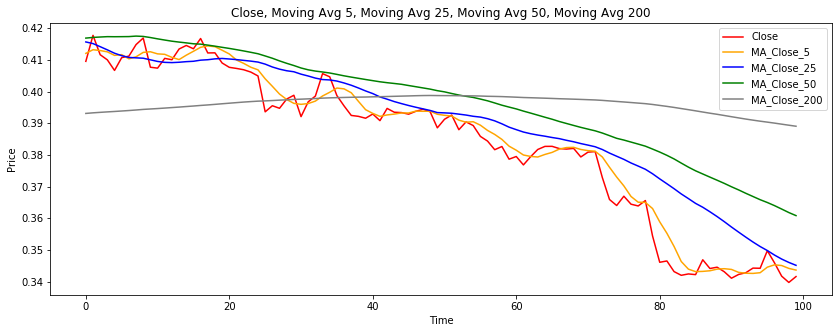

In [64]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(71621, 18)


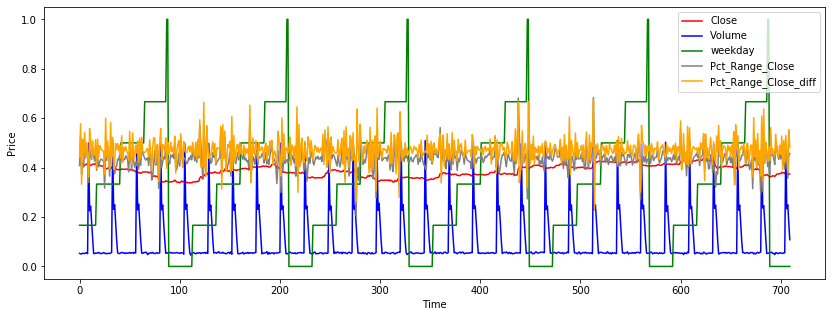

In [63]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(71621, 18)


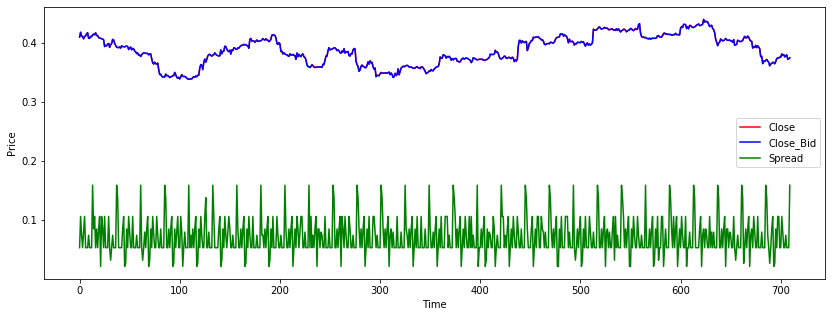

In [65]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(71621, 18)


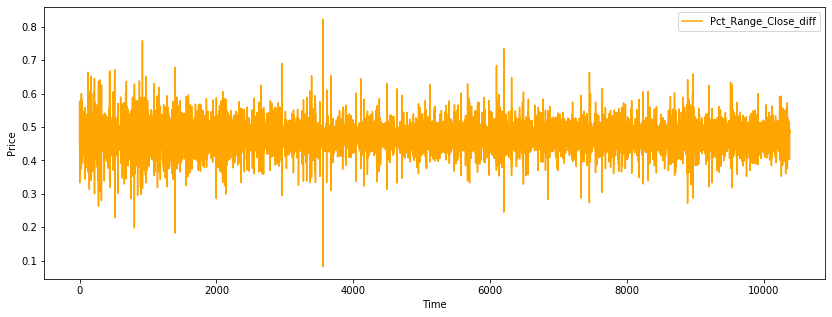

In [66]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

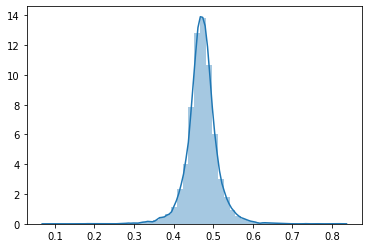

In [67]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);

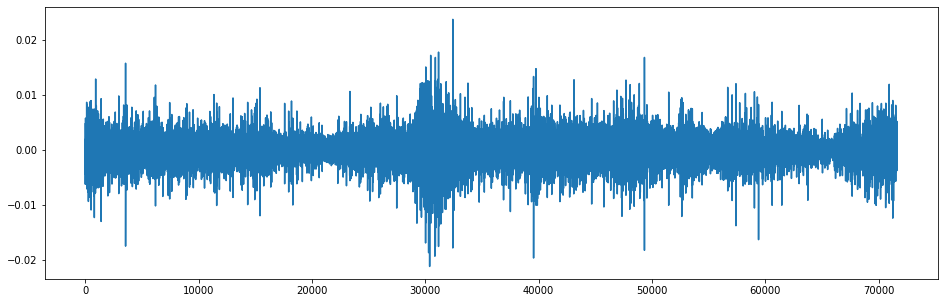

In [69]:
# Target para el entrenamiento
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [70]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(71619, 2, 18)
(71619,)


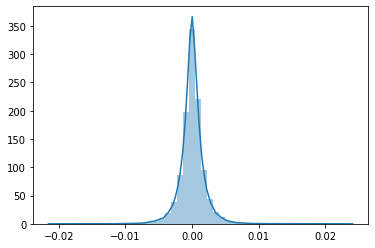

In [71]:
sns.distplot(y_train_np);



In [72]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(2, 18)
(10231, 18)
<bound method NDFrame.head of           Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0      1.11382  1.11574  1.11304  1.11556  13320.0195   1.11381   1.11571   
1      1.11553  1.11593  1.11344  1.11558   8630.7002   1.11552   1.11590   
2      1.11557  1.11614  1.11464  1.11549   5737.7500   1.11554   1.11612   
3      1.11548  1.11670  1.11508  1.11592   5463.4702   1.11546   1.11667   
4      1.11592  1.11709  1.11591  1.11698   4396.2900   1.11589   1.11706   
...        ...      ...      ...      ...         ...       ...       ...   
10228  1.05558  1.05583  1.05428  1.05530  11370.1299   1.05557   1.05581   
10229  1.05529  1.05612  1.05481  1.05571  10134.2695   1.05528   1.05610   
10230  1.05571  1.05610  1.05502  1.05534  10124.4297   1.05569   1.05608   
10231  1.05539  1.05584  1.05216  1.05342  18621.6992   1.05537   1.05582   
10232  1.05344  1.05651  1.05316  1.05613  19404.3496   1.05343   1.05649   

       Low_Bid  Close_Bid

In [73]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(2,)
(10231,)
0   -0.001526
1   -0.000099
2    0.000466
3    0.000564
4   -0.000520
5   -0.016994
6    0.016710
7   -0.001583
8    0.005319
9   -0.004980
Name: Pct_Range_Close_diff, dtype: float64


In [74]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.1203074  0.12049929 0.12085347 0.12301057 0.02709535 0.12051453
  0.12050732 0.12083974 0.12305526 0.02403917 0.01058201 0.66666667
  0.47520492 0.58692693 0.12418808 0.12378347 0.12000837 0.12276987]
 [0.1233922  0.12084151 0.12157736 0.12304666 0.01755615 0.12359956
  0.12084962 0.12158176 0.12309136 0.01560593 0.01058201 0.66666667
  0.43792831 0.43733843 0.12262325 0.12349981 0.11989857 0.12267222]
 [0.12346436 0.12121976 0.12374903 0.12288426 0.01167119 0.12363564
  0.12124597 0.12371731 0.12291088 0.01054458 0.01587302 0.66666667
  0.4355201  0.46916039 0.12178456 0.12312453 0.11981437 0.12257973]
 [0.123302   0.12222843 0.12454531 0.12366018 0.01111324 0.12349131
  0.12223683 0.12453172 0.12366892 0.0090797  0.02116402 0.66666667
  0.44690512 0.48174852 0.12106205 0.12280276 0.11971793 0.12249266]
 [0.12409576 0.12293089 0.12604738 0.12557292 0.00894234 0.12426708
  0.12293945 0.12603384 0.12563621 0.00613129 0.00529101 0.66666667
  0.46068977 0.48393849 0.12220209 0.1225623

In [75]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(10231, 2, 18)
(10231,)


In [76]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(2, 18)
(20463, 18)


(20465, 18)

In [77]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(2,)
(20463,)


(20465,)

In [78]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.1203074  0.12049929 0.12085347 0.12301057 0.02709535 0.12051453
  0.12050732 0.12083974 0.12305526 0.02403917 0.01058201 0.66666667
  0.47520492 0.58692693 0.12418808 0.12378347 0.12000837 0.12276987]
 [0.1233922  0.12084151 0.12157736 0.12304666 0.01755615 0.12359956
  0.12084962 0.12158176 0.12309136 0.01560593 0.01058201 0.66666667
  0.43792831 0.43733843 0.12262325 0.12349981 0.11989857 0.12267222]
 [0.01621778 0.01662494 0.01762673 0.01799054 0.04700939 0.01636328
  0.01662853 0.01764546 0.01803054 0.03722473 0.00529101 0.33333333
  0.46593441 0.43997605 0.01271108 0.00958642 0.00739038 0.0072144 ]
 [0.01849079 0.02179434 0.01994317 0.02215887 0.03978916 0.01869058
  0.02179905 0.01996199 0.02218171 0.03532327 0.01058201 0.33333333
  0.49084746 0.49409461 0.01414884 0.00982683 0.00737072 0.00707399]
 [0.02256778 0.02114591 0.02146334 0.01984915 0.02577214 0.02276787
  0.02115049 0.02146412 0.01987149 0.02381851 0.01058201 0.33333333
  0.40798911 0.39573913 0.0152562  0.0098781

In [79]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(20463, 2, 18)
(20463,)


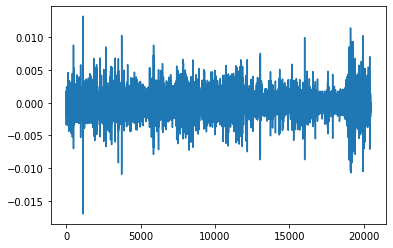

In [80]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

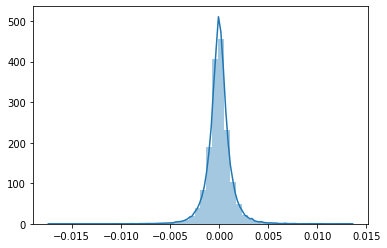

In [81]:
sns.distplot(y_test_np);


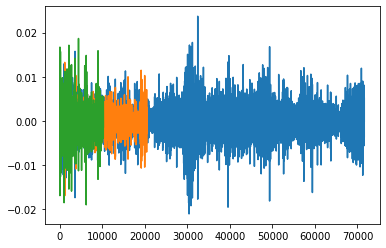

In [82]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [83]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

2
18


In [84]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 20, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

#regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 1, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


In [85]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [86]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [87]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 2)              168       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1)                 16        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [88]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/


In [89]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [90]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

#history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





Epoch 1/10
2388/2388 [==============================] - 8s 3ms/step - loss: 3.4771e-06 - mean_squared_error: 3.4771e-06 - mean_absolute_error: 0.0013 - mean_absolute_percentage_error: 878.3785 - cosine_proximity: -0.0054 - val_loss: 3.1788e-06 - val_mean_squared_error: 3.1788e-06 - val_mean_absolute_error: 0.0012 - val_mean_absolute_percentage_error: 371.9095 - val_cosine_proximity: -0.0025-06 - mean_absolute_error: 0.0013 - 
Epoch 2/10
2388/2388 [==============================] - 8s 3ms/step - loss: 3.4811e-06 - mean_squared_error: 3.4811e-06 - mean_absolute_error: 0.0013 - mean_absolute_percentage_error: 915.1638 - cosine_proximity: 0.0039 - val_loss: 3.1880e-06 - val_mean_squared_error: 3.1880e-06 - val_mean_absolute_error: 0.0012 - val_mean_absolute_percentage_error: 477.0150 - val_cosine_proximity: 0.0025
Epoch 3/10
2388/2388 [==============================] - 8s 3ms/step - loss: 3.4753e-06 - mean_squared_error: 3.4753e-06 - mean_absolute_error: 0.0013 - mean_absolute_percentage_e

In [91]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + NUM_FEATURES + '_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)
regressior.save(source_data + file_name)


LSTM_1D_12_Pct_Range_Close_diff_04.hdf5


In [92]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity'])


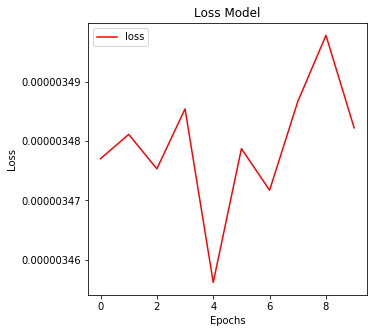

In [93]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

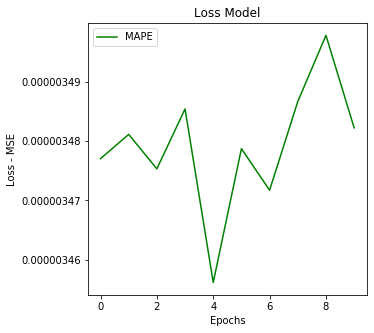

In [94]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_squared_error'][:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [95]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models/../../../Models/2020/LSTM/LSTM_1D_12_Pct_Range_Close_diff_04.hdf5


In [96]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(20463, 1)

In [97]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(71619, 1)

(20463,)
(20463, 1)


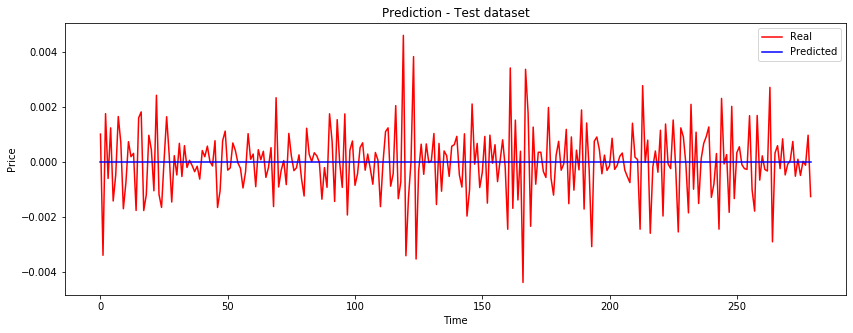

In [98]:
INICIO = 0
FIN = 280
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [99]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [100]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.0008470805244337485
Test RMSE: 0.0012662629139570877
Test MSE: 1.6034217672630948e-06
Test MAPE: inf


(71619,)


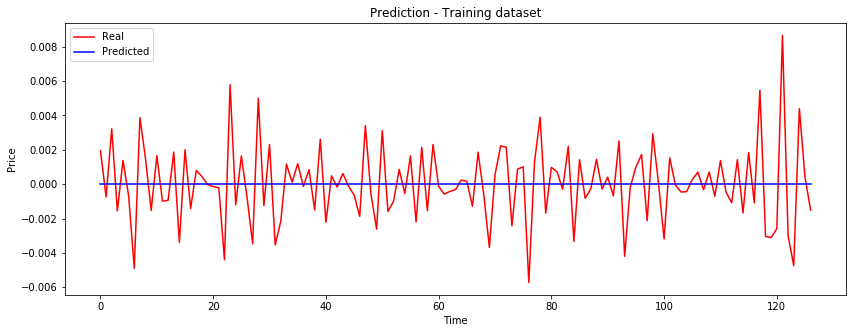

In [101]:
print(y_train_np.shape)
INICIO = 0
FIN = 127
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.0012311419925477643
Train RMSE: 0.0018321372690914429
Train MSE: 3.3567269727938503e-06
